# Feed-Forward Neural Network
This notebook uses a basic (feed-forward) artificial network to predict presence/absence of beetles in raster cells.

### "Edge" Prediction Case

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
from sklearn.preprocessing import StandardScaler

sys.path.append('../..')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
#!unzip ../../../data/cluster/edge/n/X_train.csv.zip
#!mv ./X_train.csv ../../../data/cluster/edge/n/X_train.csv

In [3]:
DATA_PATH =  '../../../data/cluster/edge/n/'
os.listdir(DATA_PATH)

['X_test.csv',
 'X_train.csv',
 'X_train.csv.zip',
 'X_valid.csv',
 'y_test.csv',
 'y_test.csv~',
 'y_train.csv',
 'y_train.csv~',
 'y_valid.csv',
 'y_valid.csv~']

In [4]:
def load_data(data_dir):
    X_train = pd.read_csv(data_dir + 'X_train.csv')
    print('X_train:', X_train.shape)
    X_valid = pd.read_csv(data_dir + 'X_valid.csv')
    print('X_valid:', X_valid.shape)
    X_test  = pd.read_csv(data_dir + 'X_test.csv')
    print('X_test:',  X_test.shape)
    y_train = pd.read_csv(data_dir + 'y_train.csv')
    print('y_train:', y_train.shape)
    y_valid = pd.read_csv(data_dir + 'y_valid.csv')
    print('y_valid:', y_valid.shape)
    y_test  = pd.read_csv(data_dir + 'y_test.csv')
    print('y_test:',  y_test.shape)
    
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [5]:
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = load_data(
    DATA_PATH)

X_train: (617805, 24)
X_valid: (131551, 24)
X_test: (132405, 24)
y_train: (617805, 1)
y_valid: (131551, 1)
y_test: (132405, 1)


In [6]:
def summarize(df, field, plot=True):
    quantiles = df.quantile(q=[0, 0.25, 0.5, 0.75, 1], axis=0)
    means = df.mean(axis=0)
    
    quants = quantiles[field]
    values = df[field]
    values = values[np.isnan(values) == False]
    n_nan  = values[np.isnan(values) == True].sum()
    is_finite = np.isfinite(values).all()

    print('\n%s:\n%10s%10s%10s%10s%10s%10s\n'
          '%10.2f%10.2f%10.2f%10.2f%10.2f%10.2f'
          % (field, 'min', '25%', 'med', 'mean', '75%', 'max',
             quants[0], quants[0.25], quants[0.5], means[field], 
             quants[0.75], quants[1]))
    if plot:
        plt.figure();
        plt.hist(values);
        plt.title(field);

In [7]:
#ignore = ['x', 'y', 'year']
#for field in list(X_train):
    #if field not in ignore:
        #summarize(X_train, field, plot=False)
        #summarize(X_valid, field, plot=False)
        #summarize(X_test,  field, plot=False)

In [8]:
#for YEAR in range(2000, 2015):
#    plt.figure()
#    plt.scatter(
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lon'], 
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lat'],
#        alpha=0.1, label=YEAR);
#    plt.legend(loc='best');

In [9]:
y_train.head()

,beetle
0,0
1,0
2,0
3,0
4,0


In [10]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y'], axis=1)
X_test  = X_test.drop(['studyArea', 'x', 'y'],  axis=1)

In [13]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
elev_srtm30                 True
dtype: bool

In [14]:
print('X_train:', 
      np.isnan(X_train.varPrecip_growingSeason).sum() / X_train.shape[0])
print('X_valid:', 
      np.isnan(X_valid.varPrecip_growingSeason).sum() / X_valid.shape[0])
print('X_test:',  
      np.isnan(X_test.varPrecip_growingSeason).sum() / X_test.shape[0])

X_train: 0.0
X_valid: 0.00930437624952
X_test: 0.0231864355576


In [15]:
# NaNs in less than 1% of the rows.... just drop
def drop_nans(X_df, y_df, field, verbose=True):
    X = X_df.copy()
    y = y_df.copy()
    X = X.loc[np.isnan(X_df[field]) == False, :]
    y = y.loc[np.isnan(X_df[field]) == False, :]
    
    if verbose:
        print(X.shape, y.shape)
    return X, y


X_train, y_train = drop_nans(X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = drop_nans(X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = drop_nans(X_test,  y_test,  'varPrecip_growingSeason')

(617805, 21) (617805, 1)
(130327, 21) (130327, 1)
(129335, 21) (129335, 1)


In [16]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [17]:
def vectorize(y):
    y = y.tolist()
    for i in range(len(y)):
        y[i] = [1, 0] if y[i] == [0] else [0, 1]
        
    return np.array(y)

In [18]:
y_train = y_train.as_matrix()
y_valid = y_valid.as_matrix()
y_test  = y_test.as_matrix()

In [19]:
y_train = vectorize(y_train)
y_valid = vectorize(y_valid)
y_test  = vectorize(y_test)

# Neural Net Model

In [20]:
best_val_loss = np.inf
X_train.shape

(617805, 21)

In [77]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
N_LAYERS = 15
NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
NODES_PER_LAYER.append(n_outputs)
ETA = 0.1
DROPOUT = 0.5
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 50
BATCH_SIZE = 1024

NODES_PER_LAYER

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2]

In [78]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [79]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 21)                462       
_________________________________________________________________
batch_normalization_51 (Batc (None, 21)                84        
_________________________________________________________________
activation_51 (Activation)   (None, 21)                0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 21)                462       
_________________________________________________________________
batch_normalization_52 (Batc (None, 21)                84        
_________________________________________________________________
activation_52 (Activation)   (None, 21)                0         
__________

In [80]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [81]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=50)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start

Train on 617805 samples, validate on 130327 samples
Epoch 1/50
617805/617805 [==============================] - 30s 48us/step - loss: 0.3858 - acc: 0.8071 - val_loss: 0.3419 - val_acc: 0.8492
Epoch 2/50
617805/617805 [==============================] - 21s 34us/step - loss: 0.3429 - acc: 0.8099 - val_loss: 0.2969 - val_acc: 0.8492
Epoch 3/50
617805/617805 [==============================] - 21s 34us/step - loss: 0.3362 - acc: 0.8117 - val_loss: 0.2974 - val_acc: 0.8492
Epoch 4/50
617805/617805 [==============================] - 21s 33us/step - loss: 0.3327 - acc: 0.8119 - val_loss: 0.3089 - val_acc: 0.8492
Epoch 5/50
617805/617805 [==============================] - 21s 34us/step - loss: 0.3287 - acc: 0.8134 - val_loss: 0.2936 - val_acc: 0.8492
Epoch 6/50
617805/617805 [==============================] - 21s 34us/step - loss: 0.3283 - acc: 0.8135 - val_loss: 0.3009 - val_acc: 0.8492
Epoch 7/50
617805/617805 [==============================] - 21s 34us/step - loss: 0.3269 - acc: 0.8140 - val

In [82]:
print('Time: %.2f minutes' % (elapsed / 60))

Time: 18.17 minutes


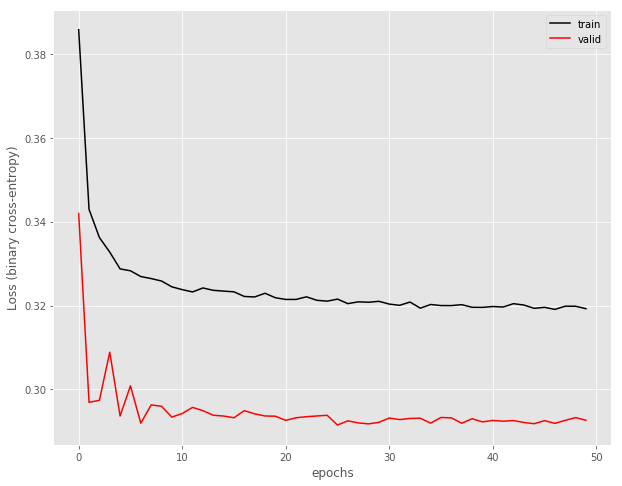

In [83]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

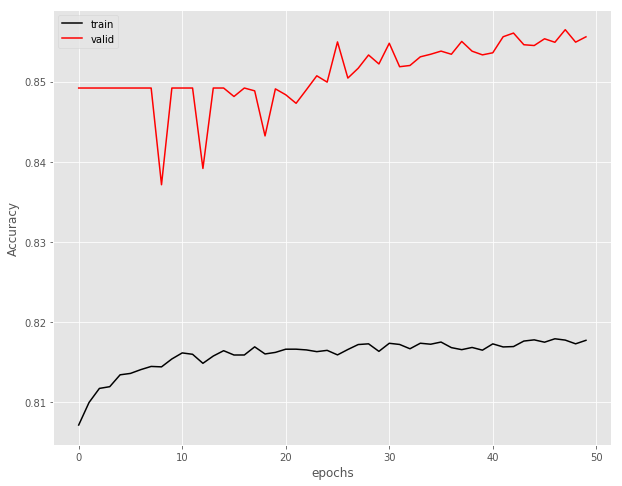

In [84]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [85]:
this_run = np.mean(history.history['val_loss'][-20:])
this_run_acc = np.mean(history.history['val_acc'][-20:])
print('This run: %.5f' % this_run)

This run: 0.29261


In [86]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    best_val_acc  = this_run_acc
    train_loss_of_best = np.mean(history.history['loss'][-20:])
    train_acc_of_best = np.mean(history.history['acc'][-20:])
    best_params = get_params()
print('Best validation loss so far: %.5f\tAcc: %.5f' % (best_val_loss, best_val_acc))
print('Training loss of same model: %.5f\tAcc: %.5f' % (train_loss_of_best, train_acc_of_best))
print('Best hyperparameters found so far:')
pprint(best_params)

Best validation loss so far: 0.29146	Acc: 0.87227
Training loss of same model: 0.24848	Acc: 0.88315
Best hyperparameters found so far:
{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0.2,
 'EPOCHS': 50,
 'EPSILON': 1e-08,
 'ETA': 0.1,
 'NODES_PER_LAYER': [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2]}


Overfitting